## Expected Free Energy for oscillator with nonlinear observations

Wouter Kouw, last update: 20-11-2022

### System

Consider a [pendulum](https://en.wikipedia.org/wiki/Pendulum_(mechanics)) with angle $\theta(t)$, driving force $u(t)$ and noise $w(t)$. The continuous-time dynamics of the system are:

$$\begin{align*}
m l^2 \ddot{\theta} + c l \dot{\theta} + m \mathcal{g} l \sin \theta = u \, ,
\end{align*}$$
where $m = \text{mass}$, $l  = \text{length}$, $c = \text{friction}$, and $\mathcal{g} = \text{gravity}$. 

#### Multivariate first-order system

With the variable substitution $z = [\theta \ \dot{\theta}]$, I cast the above system into a multi-variate first-order form:

$$ \begin{bmatrix} \dot{\theta} \\ \ddot{\theta} \end{bmatrix} = \begin{bmatrix} \dot{\theta} \\ -\frac{\mathcal{g}}{l} \sin \theta - \frac{c}{ml} \dot{\theta} \end{bmatrix} + \begin{bmatrix} 0 \\ \frac{1}{ml^2} \end{bmatrix} u \, .$$

#### Discretization

A forward Euler discretization for the state transition yields:

$$\begin{align*}
z_k =&\ \underbrace{z_{k-1} + \Delta t\begin{bmatrix} z_{2,k-1} \\ -\frac{\mathcal{g}}{l} \sin (z_{1,k-1}) - \frac{c}{ml} z_{2,k-1} \end{bmatrix} + \begin{bmatrix} 0 \\ \frac{\Delta t}{ml^2} \end{bmatrix} u_k}_{f(z_{k-1}, u_k)} \, .
\end{align*}$$

We have noisy observations of a nonlinear function $g$ of the displacement, 

$$ y_k = g(z_k) + r_k \quad \text{where} \quad r_k \sim \mathcal{N}(0, R) \, .$$

The unscented transform can be used to form a probabilistic model:



In [1]:
# using Pkg
# Pkg.activate(".")
# Pkg.instantiate()

  Activating project at `~/syndr/Wouter/Onderzoek/Projecten/tue/efe-planning/ECC2023-efe4ukf`


In [1]:
using Revise
using Optim
using ForwardDiff
using Zygote
using ProgressMeter
using LinearAlgebra
using ControlSystems
using Distributions
using Plots
default(label="", grid=false, linewidth=3, markersize=3, margin=10Plots.pt)
include("util.jl")

UT (generic function with 1 method)

In [7]:
# System parameters
mass = 2.0
leng = 1.0
fric = 4.0
const gravity = 9.81

# Temporal variables
Δt = 0.1
len_time = 300
time = range(0, step=Δt, length=len_time)

# Matrices
# f(z::AbstractVector) = [z[1] + Δt*z[2]; z[2] + Δt*(-gravity/length*sin(z[1])-friction/(mass*length^2)*z[2]) + Δt/(mass*length^2)*z[3]]
# Fz(z::AbstractVector) = ForwardDiff.jacobian(f,z)*[1 0;0 1; 0 0]
f(z::AbstractVector, u::Real) = [z[1] + Δt*z[2]; z[2] + Δt*(-gravity/leng*sin(z[1])-fric/(mass*leng^2)*z[2]) + Δt/(mass*leng^2)*u]
# Fz(z::AbstractVector, u::Real) = Zygote.jacobian(f,z,u)
Fz(z::AbstractVector) = [1 Δt; -Δt*gravity/leng*cos(z[1]) 1-Δt*fric/(mass*leng^2)]

# Linearized
# A = [1 Δt; -Δt*gravity/length -friction/(mass*length^2)]
# B = [0; Δt/(mass*length^2)]

# Process noise
Q = 1e-8*diagm(ones(2))

# Measurement noise
R = 1e-3;

# Nonlinear observation
g(z) = leng*sin([1.0,0.0]'*z)

g (generic function with 1 method)

In [8]:
function update(z_kmin1, u_k)
   "Update environment" 
    
    # State transition
    z_k = f(z_kmin1, u_k)
    
    # Emit noisy observation
    y_k = rand(Normal(g(z_k), sqrt(R)))
    
    return y_k, z_k
end;

In [9]:
# Control
cutpoint = 100
u = [sin.((1:cutpoint)./ 2π); zeros(len_time-cutpoint)];

In [10]:
# Initial state
z_0 = [0.0, 0.0]

# Preallocate
z = zeros(2,len_time)
y = zeros(len_time)

# Start recursion
z_kmin1 = z_0
for k in 1:len_time
    
    # Update system
    y[k], z[:,k] = update(z_kmin1, u[k])
    
    # Update recursion
    z_kmin1 = z[:,k]
    
end

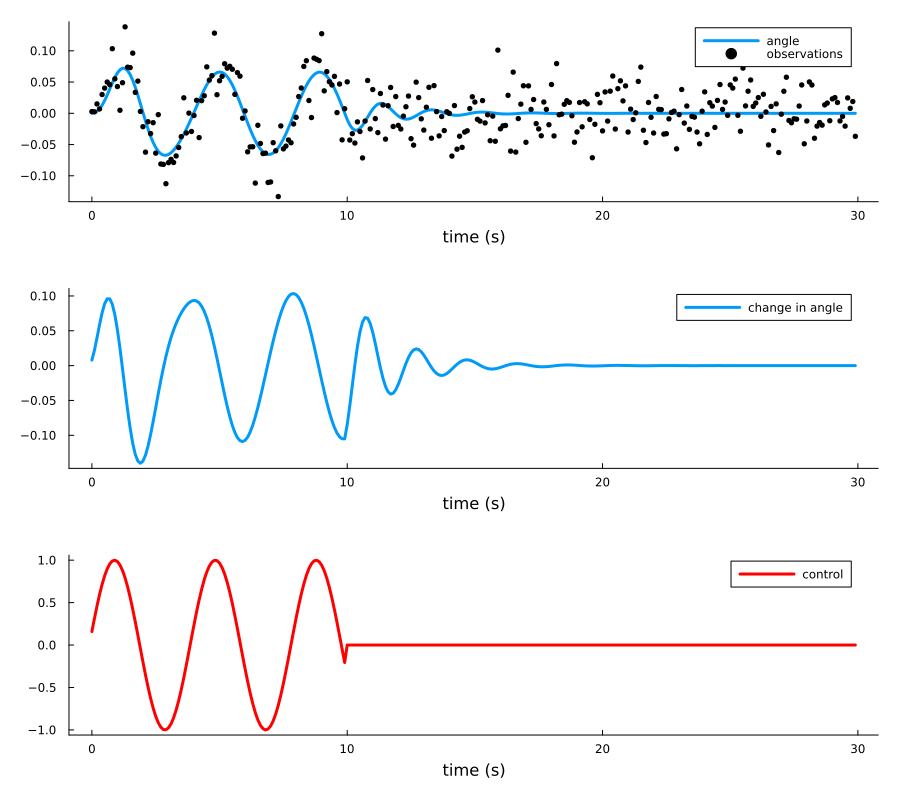

In [11]:
p1 = plot(time, z[1,:], xlabel="time (s)", label="angle")
scatter!(time, y, color="black", label="observations")
p2 = plot(time, z[2,:], xlabel="time (s)", label="change in angle")
p3 = plot(time, u, color="red", xlabel="time (s)", label="control")
plot(p1, p2, p3, layout=(3,1), size=(900,800))

## Generative model

Starting with a prior state $p(z_0) = \mathcal{N}(z_0 \mid m_0, S_0)$, we will approximate the result $z_1 = f(z_0, u_k = \hat{u}_k)$ with an unscented transform:

$$\begin{align}
p(z_1, z_0 \mid u_1) = \mathcal{N}\left(\begin{bmatrix} z_0 \\ z_1 \end{bmatrix} \mid \begin{bmatrix} m_0 \\ \tilde{m}_1 \end{bmatrix} , \begin{bmatrix} S_0 & \tilde{C}_1 \\ \tilde{C}_1^{\top} & \tilde{S}_1 \end{bmatrix} \right) \, .
\end{align}$$

The joint Gaussian for $z_k, z_{k-1}$ can be decomposed into a conditional distribution that serves as the state transition:

$$\begin{align}
p(z_k \mid z_{k-1} \mid u_k) = \mathcal{N}\left(z_k \mid \tilde{m}_k - \tilde{C}_k^{\top} S_k^{-1} (z_{k-1} - m_{k-1}), \tilde{S}_k - \tilde{C}^{\top}_k S_{k-1}^{-1} \tilde{C}_k \right) \, .
\end{align}$$

and the marginal distribution $p(z_k \mid u_k) = \mathcal{N}\left(z_k \mid \tilde{m}_k, \tilde{S}_k \right)$.

In [12]:
# Preallocate
z_est = (zeros(2,len_time), zeros(2,2,len_time))

# Initial belief
m_0 = zeros(2)
S_0 = diagm(ones(2))

# Start recursion
m_kmin1 = m_0
S_kmin1 = S_0

for k in 1:len_time
    
    # Prediction step
    # Jz,Ju    = Fz(m_kmin1, u[k])
    Jz       = Fz(m_kmin1)
    m_k_pred = f(m_kmin1, u[k])
    S_k_pred = Jz*S_kmin1*Jz'
    
    # Regularize approximation
    S_k_pred += 1e-8*diagm(ones(2))
    
    # Correction step
    mU, SU, CU = UT(m_k_pred, S_k_pred, g, Q=R)
    K_t = CU*inv(SU)
    m_k = m_k_pred .+ K_t*(y[k] - mU)
    S_k = S_k_pred .- K_t*SU*K_t'
    
    # Store state estimates
    z_est[1][:,k]   = m_k
    z_est[2][:,:,k] = S_k
   
    # Update recursion
    m_kmin1 = m_k
    S_kmin1 = S_k
    
end

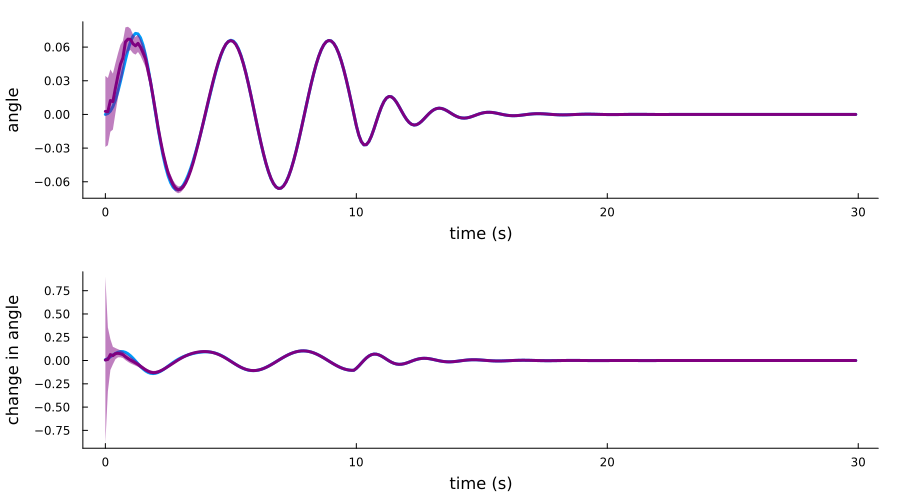

In [13]:
p1 = plot(time, z[1,:], xlabel="time (s)", ylabel="angle")
plot!(time, z_est[1][1,:], ribbon=sqrt.(z_est[2][1,1,:]), color="purple")
p2 = plot(time, z[2,:], xlabel="time (s)", ylabel="change in angle")
plot!(time, z_est[1][2,:], ribbon=sqrt.(z_est[2][2,2,:]), color="purple")
plot(p1, p2, layout=(2,1), size=(900,500))

## Expected Free Energy

From the agent's viewpoint, the evolution of these future variables are constrained by its generative model, rolled out into the future:
$$\begin{align}
p(y,z,u) &= \underbrace{q(z_{k})}_{\substack{\text{current}\\ \text{state}}} \cdot \underbrace{\prod_{t=k+1}^{k+T} p(y_t|z_t) \cdot p(z_t | z_{t-1}, u_t) p(u_t)}_{\text{generative model roll-out to future}} \, ,
\end{align}$$

where $y = (y_t, \dots, y_T)$, $z = (z_{t-1}, \dots, z_T)$ and $u = (u_t, \dots, u_T)$. 

Consider the varational free energy functional for estimating posterior beliefs $q(z,u)$ over future states and control signals, with an expectation over future observations $q(y \mid z)$: 

$$\begin{align}
H[q] &= \overbrace{\iint q(y \mid z)}^{\text{marginalize }y} \bigg( \overbrace{\int q(z,u) \log \frac{q(z,u)}{p(y,z,u)} }^{\text{variational free energy}}\bigg) \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(y,z,u) \log \frac{q(z,u)}{p(y,z,u)} \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(y,z|u) q(u) \log \frac{q(z|u) q(u)}{p(y,z|u) p(u)} \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(u) \bigg(\sum_{y,z} q(y,z|u) \log \frac{q(z|u) q(u)}{p(y,z|u) p(u)}\bigg) \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(u) \bigg( \log q(u) + \log \frac{1}{p(u)}+ \underbrace{q(y,z|u) \log \frac{q(z|u)}{p(y,z|u)}}_{G(u)}\bigg) \mathrm{d}u \, \mathrm{d}y \, \mathrm{d}z \\
&= \int q(u) \log \frac{q(u)}{p(u)\exp\left(- G(u)\right) } \mathrm{d}u  \, .
\end{align}$$

We can recognize a KL-divergence between $q(u)$ and the function $p(u)\exp\left(- G(u)\right)$, which will be minimal when $q(u) = p(u)\exp\left(- G(u)\right)$. The $G$ function is known as the _Expected Free Energy_. Let's look at it in detail for a future observation $t$,

$$ G(u_t) = \iint q(y_t, z_t \mid u_t) \log \frac{q(z_t \mid u_t)}{p(y_t, z_t \mid u_t)} \mathrm{d}y_t \, \mathrm{d}z_t \, ,$$

where 

$$\begin{align}
% q(y_t \mid z_t) &= \mathcal{N}(y_t \mid Cz_t, R) \\
% q(z_t \mid u_t) &= \int p(z_t \mid z_{t-1}, u_t) q(z_{t-1}) \mathrm{d}z_{t-1} \\
% &= \mathcal{N}(z_t \mid A m_{t-1} + Bu_t, AS_{t-1}A^{\top} + Q) \\
p(y_t, z_t \mid u_t) &= \int p(y_t \mid z_t) p(z_t \mid z_{t-1}, u_t) q(z_{t-1}) \mathrm{d}z_{t-1} \\
&= \mathcal{N}(\begin{bmatrix} y_t \\ z_t \end{bmatrix} \mid \begin{bmatrix} C(A m_{t-1} + Bu_t) \\ A m_{t-1} + Bu_t \end{bmatrix}, \begin{bmatrix} C(AS_{t-1}A^{\top} + Q) C^{\top} + R & C(AS_{t-1}A^{\top} + Q) \\ (AS_{t-1}A^{\top} + Q)C^{\top} & AS_{t-1}A^{\top} + Q \end{bmatrix}) \, ,
\end{align}$$

with the approximate posterior for the previous state $q(z_{t-1}) = \mathcal{N}(z_{t-1} \mid m_{t-1}, S_{t-1})$. The distribution $q(z_t \mid u_t)$ is constructed from the state transition:

$$q(z_t \mid u_t) = \int p(z_t \mid z_{t-1}, u_t) q(z_{t-1}) \mathrm{d}z_{t-1} = \mathcal{N}(z_t \mid A m_{t-1} + Bu_t, AS_{t-1}A^{\top} + Q) \, ,$$

and $q(y_t, z_t \mid u) = p(y_t \mid z_t) q(z_t \mid u_t)$ which is equivalent to $p(y_t, z_t \mid u_t)$ in this case. Note that - during planning and in linear Gaussian models - we can drive the KL-divergence between the approximate posteriors $q$ and the true posteriors $p$ to 0, thus allowing us to swap $q$ for $p$.

We will decompose this EFE function into ambiguity plus risk terms (see [lecture slides](https://nbviewer.org/github/bertdv/BMLIP/blob/master/lessons/notebooks/Intelligent-Agents-and-Active-Inference.ipynb) for more detail). To do so, we will decompose $p(y_t,z_t \mid u_t)$ into $p^\prime(y_t)p(z_t|y_t,u_t)$ where $p\prime(y_t)$ is a distribution over the goal state, a.k.a. a _goal prior_; $p^\prime(y) = \mathcal{N}(y \mid m_*, s_*)$. The derivation goes as follows:

$$\begin{align}
G(u_t) &= \int  q(y_t,z_t|u_t) \log \frac{q(z_t|u_t)}{p^\prime(y_t)p(z_t|y_t,u_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t, z_t \mid u_t) \log \frac{q(z_t \mid u_t)}{p^\prime(y_t)} \frac{1}{p(z_t \mid y_t, u_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t, z_t \mid u_t) \log \frac{q(z_t \mid u_t)}{p^\prime(y_t)} \frac{p(y_t \mid u_t)}{p(y_t \mid z_t)p(z_t \mid u_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t,z_t|u_t) \log \frac{q(z_t|u_t)}{p(y_t|z_t)p(z_t|u_t)} \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  q(y_t,z_t|u_t) \log \frac{q(z_t|u_t)}{p(y_t|z_t)p(z_t|u_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t + \int q(y_t,z_t|u_t) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t \, \mathrm{d}z_t \\
&= \int  p(z_t|u_t) p(y_t|z_t) \log \frac{1}{p(y_t|z_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t + \int p(z|u) p(y|z) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t \\
&= \underbrace{\int  p(z_t|u_t) \int p(y_t|z_t) \log \frac{1}{p(y_t|z_t)} \, \mathrm{d}z_t \, \mathrm{d}y_t}_{\text{ambiguity}} + \underbrace{\int p(y_t|u_t) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t}_{\text{risk}} \ \, ,
\end{align}$$

Ambiguity is an expectation over an entropy, which - in the case of a Gaussian likelihood - is actually independent of the state,

$$\int p(y_t|z_t) \log p(y_t|z_t) \mathrm{d}y_t = \frac{1}{2}\big(\log 2\pi |R| - 1\big) \, ,$$

so the expectation over $p(z_t|u_t)$ doesn't even apply. As you may have noticed, the control $u_t$ doesn't affect ambiguity which means there is no information-seeking behaviour in linear Gaussian state-space models.

The risk term is a KL-divergence between the Gaussian,

$$\begin{align}
    p(y_t|u_t) &= \int p(y_t, z_t \mid u_t) \, \mathrm{d}z_t  \\
    &= \int \mathcal{N}(\begin{bmatrix} y_t \\ z_t \end{bmatrix} \mid \begin{bmatrix} C(A m_{t-1} + Bu_t) \\ A m_{t-1} + Bu_t \end{bmatrix}, \begin{bmatrix} C(AS_{t-1}A^{\top} + Q) C^{\top} + R & C(AS_{t-1}A^{\top} + Q) \\ (AS_{t-1}A^{\top} + Q)C^{\top} & AS_{t-1}A^{\top} + Q \end{bmatrix}) \, \mathrm{d}z_t \\
    &= \mathcal{N}(y_t \mid C(A m_{t-1} + Bu_t) , C(AS_{t-1}A^{\top} + Q) C^{\top} + R) \, ,
    \end{align}$$
    
and the goal prior $p^\prime(y_t)$. The formula for the KL-divergence between two Gaussians is (see [wiki](https://en.wikipedia.org/wiki/Kullback%E2%80%93Leibler_divergence#Multivariate_normal_distributions)):

$$\begin{align}
D_{\text{KL}}( \mathcal{N}(x \mid m_1, \sigma_1) || \mathcal{N}(x \mid m_2, \sigma_2) ) = \frac{1}{2} \Big[\log\frac{|\Sigma_2|}{|\Sigma_1|} - d + \text{tr}(\Sigma_2^{-1}\Sigma_1) + (\mu_2 - \mu_1)^{\top}\Sigma_2^{-1}(\mu_2 - \mu_1) \Big] \, .
\end{align}$$

For our distribution, this becomes:

$$\int p(y_t|u_t) \log \frac{p(y_t|u_t)}{p^\prime(y_t)} \, \mathrm{d}y_t = \frac{1}{2} \Big[\log\frac{s_*}{|C(AS_{t-1}A^{\top} + Q) C^{\top} + R|} - 1 + \text{tr}(\frac{(C(AS_{t-1}A^{\top} + Q) C^{\top} + R)}{s_*}) + \frac{\big(m_* - (C(A m_{t-1} + Bu_t))\big)^2}{s_*}) \Big]$$


The decomposition is the same for any future state $t$. We may thus unroll the policy as $G(u) = \sum_{t=k+1}^{TT} G(u_t)$.

---

The above equations can be written down to form an objective function.

In [67]:
function EFE(u::AbstractVector, 
             state::Tuple{AbstractVector, AbstractMatrix}, 
             goal::Tuple{Float64,Float64}; 
             time_horizon::Int64=1)
    "Expected Free Energy"
    
    # Unpack goal state
    m_star, S_star = goal
    iS = inv(S_star)
    
    # Unpack parameters of current state
    m_tmin1, S_tmin1 = state
    
    # Start cumulative sum
    cEFE = 0.0
    for t in 1:time_horizon
        
        # State transition p(z_t | u_t)
        # Jz,Ju = Fz(m_tmin1, u[t])
        Jz    = Fz(m_tmin1)
        m_t   = f(m_tmin1, u[t])
        S_t = Jz*S_tmin1*Jz'
        
        # Regularize
        S_t  += 1e-8*diagm(ones(2))

        # Unscented transform moments
        mU, SU, _ = UT(m_t, S_t, g, Q=R, D=1)
        
        # E_q(z_t | u_t)[H[q(y_t | z_t)]]
        ambiguity = 0.5(log(2π) + log(SU) - 1)
        # ambiguity = 0.5(log(2π) + log(SU-CU'*inv(S_t)*CU) - 1)

        # D_KL[p(y_t | u_t) || p'(y_t)]
        risk = 0.5(log(det(S_star)/det(SU)) + 1 + (mU-m_star)'*iS*(mU-m_star) + tr(iS*SU))
        
        # Cumulate EFE
        cEFE += ambiguity + risk
        
        # Update state recursion
        m_tmin1 = m_t
        S_tmin1 = S_t
                
    end
    return cEFE
end

EFE (generic function with 1 method)

We can use the Optim.jl library to auto-differentiate EFE and minimize it every time step.

In [77]:
len_trial = 30
time = range(0, step=Δt, length=len_trial)

# Time horizon
len_horizon = 2;

In [82]:
include("util.jl")

UT (generic function with 1 method)

In [83]:
# Distribution around goal state
goal_state = (3.14, 1e-2)

# Limits of controller
u_lims = (-100.0, 100.0)

# Preallocate
z_est = (zeros(2,len_trial), zeros(2,2,len_trial))
z_sim = zeros(2,len_trial)
y_sim = zeros(len_trial)
u_sim = zeros(len_trial)

# Initial belief
m_0 = zeros(2)
S_0 = diagm(ones(2))

# Actual initial state
z_sim[:,1] = z_0

# Start recursion
m_kmin1 = m_0
S_kmin1 = S_0

@showprogress for k in 2:len_trial
    
    "Interact with environment"
    
    # Update system with selected control
    y_sim[k], z_sim[:,k] = update(z_sim[:,k-1], u_sim[k-1])
   
    "State estimation"
    
    # Prediction step
    # Jz,Ju    = Fz(m_kmin1, u_sim[k-1])
    Jz       = Fz(m_kmin1)
    m_k_pred = f(m_kmin1, u_sim[k-1])
    S_k_pred = Jz*S_kmin1*Jz'
    
    # Regularize
    S_k_pred += 1e-8*diagm(ones(2))
    
    # Correction step
    mU, SU, CU = UT(m_k_pred, S_k_pred, g, Q=R)
    K_t = CU*inv(SU)
    m_k = m_k_pred .+ K_t*(y_sim[k] - mU)
    S_k = S_k_pred .- K_t*SU*K_t'
    
    # Store state estimates
    z_est[1][:,k] = m_k
    z_est[2][:,:,k] = S_k
    
    "Planning"
    
    # Single-argument objective
    G(u::AbstractVector) = EFE(u, (m_k,S_k), goal_state, time_horizon=len_horizon)
    
    # Call minimizer using constrained L-BFGS procedure
    results = Optim.optimize(G, u_lims[1], u_lims[2], zeros(len_horizon), Fminbox(LBFGS()); autodiff=:forward)
    
    # Extract minimizing control
    u_sim[k] = Optim.minimizer(results)[1]
   
    # Update recursion
    m_kmin1 = m_k
    S_kmin1 = S_k
    
end

LoadError: LAPACKException(1)

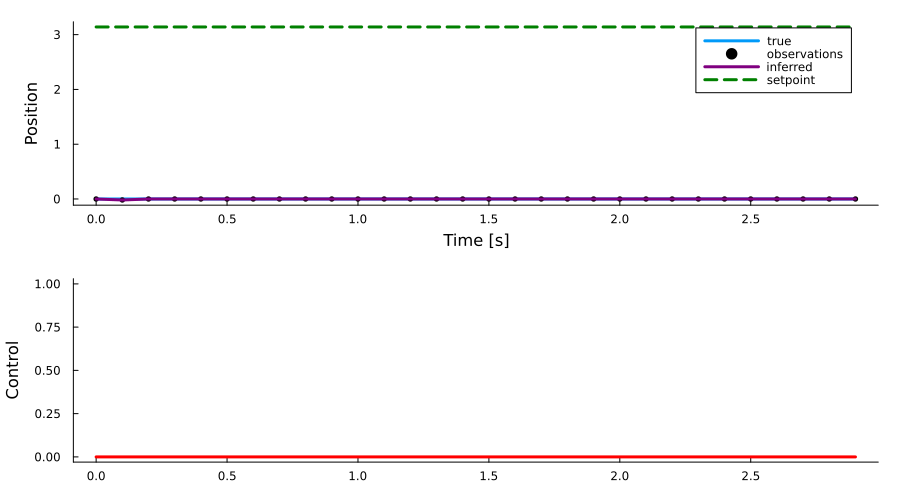

In [76]:
p301 = plot(time, z_sim[1,:], label="true", ylabel="Position", xlabel="Time [s]")
scatter!(time, y_sim, label="observations", color="black")
plot!(time, z_est[1][1,:], label="inferred", color="purple")
plot!(time, goal_state[1]*ones(len_trial), color="green", linestyle=:dash, label="setpoint")
p302 = plot(time, u_sim, color="red", ylabel="Control")
plot(p301, p302, layout=(2,1), size=(900,500))

### Trajectory

In [16]:
len_trial = 30
time = range(0, step=Δt, length=len_trial)

# Time horizon
len_horizon = 5;

In [17]:
function planned_trajectory(policy, current_state)
    "Generate future states and observations"
    
    # Extract time horizon
    time_horizon = length(policy)
    
    # Unpack parameters of current state
    m_tmin1, S_tmin1 = current_state
    
    # Track predicted observations
    z_m = zeros(2,time_horizon)
    z_S = zeros(2,2,time_horizon)
    y_m = zeros(time_horizon)
    y_v = zeros(time_horizon)
    
    for t in 1:time_horizon
        
        # State transition
        z_m[:,t] = A*m_tmin1 + B*policy[t]
        z_S[:,:,t] = A*S_tmin1*A' + Q
        
        # Predicted observations
        y_m[t],y_v[t],_ = UT(z_m[:,t],z_S[:,:,t],g,R)
        
        # Update previous state
        m_tmin1 = z_m[:,t]
        S_tmin1 = z_S[:,:,t]
        
    end
    return z_m, z_S, y_m, y_v
end

planned_trajectory (generic function with 1 method)

In [18]:
# Distribution around goal state
goal_state = (y_star, 1e-5)

# Limits of controller
u_lims = (-100.0, 100.0)

# Preallocate
z_est = (zeros(2,len_trial), zeros(2,2,len_trial))
z_pln = (zeros(len_trial, 2,len_horizon), zeros(len_trial, 2,2,len_horizon))
y_pln = (zeros(len_trial, len_horizon), zeros(len_trial,len_horizon))
z_sim = zeros(2,len_trial)
y_sim = zeros(len_trial)
u_sim = zeros(len_trial)

# Initial belief
m_0 = ones(2)
S_0 = 3.0*diagm(ones(2))

# Start recursion
m_kmin1 = m_0
S_kmin1 = S_0
z_kmin1 = z_0

@showprogress for k in 2:len_trial
    
    "Interact with environment"
    
    # Update system with selected control
    y_sim[k], z_sim[:,k] = update(z_sim[:,k-1], u_sim[k-1])
   
    "State estimation"
    
    # Prediction step
    m_k_pred = A*m_kmin1 + B*u_sim[k-1]
    S_k_pred = A*S_kmin1*A' .+ Q

    # Correction step
    mU, SU, CU = UT(m_k_pred, S_k_pred, g, R)
    K_t = CU*inv(SU)
    m_k = m_k_pred .+ K_t*(y_sim[k] - mU)
    S_k = S_k_pred .- K_t*SU*K_t'
    
    # Store state estimates
    z_est[1][:,k] = m_k
    z_est[2][:,:,k] = S_k
    
    "Planning"
    
    # Single-argument objective
    G(u_t::AbstractVector) = EFE(u_t, (m_k, S_k), goal_state, time_horizon=len_horizon)
    
    # Call minimizer using constrained L-BFGS procedure
    results = Optim.optimize(G, u_lims[1], u_lims[2], zeros(len_horizon), Fminbox(LBFGS()); autodiff=:forward)
    policy = Optim.minimizer(results)
    
    # Planning
    z_pln[1][k,:,:], z_pln[2][k,:,:,:], y_pln[1][k,:], y_pln[2][k,:] = planned_trajectory(policy, (m_k,S_k))
    
    # Execute first planned action only
    u_sim[k] = policy[1]
   
    # Update recursion
    m_kmin1 = m_k
    S_kmin1 = S_k
    
end

LoadError: UndefVarError: y_star not defined

In [19]:
anim = @animate for k = 2:(len_trial-len_horizon)
    
    p201 = plot(time, y_star*ones(len_trial), color="green", linestyle=:dash, label="setpoint", ylims=[-1.5, 1.0])
    scatter!(time[1:k], y_sim[1:k], color="black", label="observations")
    plot!(time[k:k+len_horizon-1], y_pln[1][k,:], ribbon=sqrt.(y_pln[2][k,:]), label="planned", color="orange")
    
    p202 = plot(time[1:k], z_sim[1,1:k], xlims=[time[1], time[end]], label="true", ylabel="Position", xlabel="Time [s]")
    plot!(time[k:k+len_horizon-1], z_pln[1][k,1,:], ribbon=sqrt.(z_pln[2][k,1,1,:]), label="planned", color="orange")
    plot!(time[1:k], z_est[1][1,1:k], ribbon=sqrt.(z_est[2][1,1,1:k]), label="inferred", color="purple", ylims=[-2,2])
    
    p203 = plot(time[1:k], u_sim[1:k], xlims=[time[1], time[end]], color="red", ylabel="Control", ylims=u_lims.*1.1)
    
    plot(p201, p202, p203, layout=(3,1), size=(900,900))
end
gif(anim, "figures/planning.gif")

LoadError: UndefVarError: y_star not defined

In [20]:
function EFE(u::AbstractVector, 
             state::Tuple{Vector{Float64}, Matrix{Float64}}, 
             goal::Tuple{Float64,Float64}; 
             time_horizon::Int64=1)
    "Expected Free Energy"
    
    # Unpack goal state
    m_star, S_star = goal
    iS = inv(S_star)
    
    # Unpack parameters of current state
    m_tmin1, S_tmin1 = state
    
    # Start cumulative sum
    cAmbiguity = 0.0
    cRisk      = 0.0
    for t in 1:time_horizon
        
        # State transition p(z_t | u_t)
        ff(x::AbstractVector) = f(x, u[t])
        m_t, S_t,_ = UT(m_tmin1, S_tmin1, ff, D=2)

        # Unscented transform moments
        mU, SU, CU = UT(m_t, S_t, g, Q=R, D=1)
        
        # E_q(z_t | u_t)[H[q(y_t | z_t)]]
        ambiguity = 0.5(log(2π) + log(SU-CU'*inv(S_t)*CU) - 1)

        # D_KL[p(y_t | u_t) || p'(y_t)]
        risk = 0.5(log(det(S_star)/det(SU)) + 1 + (mU-m_star)'*iS*(mU-m_star) + tr(iS*SU))
        
        # Cumulate EFE terms
        cAmbiguity += ambiguity
        cRisk +    = risk
        
        # Update state recursion
        m_tmin1 = m_t
        S_tmin1 = S_t
                
    end
    return cAmbiguity, cRisk
end

LoadError: syntax: unexpected "="